# Chris Klausmeier's model for arid vegetation patterns
Although the Klausmeier model is not marine, we use it in this marine course because of the model's conciseness. 
### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter definitions 

In [2]:
# Parameters       Original value    Explanation and Units
a        = 1.5     # 2.0             Rainfall rate
m        = 0.45    # 0.45            Mortality rate

v        = 182.0   # 182             The downslope advection of W 
dw       = 10.0    # 10              The diffusion constant of W
dn       = 1.0     # 1.0             The diffusion constant of N

### Simulation settings

In [3]:
EndTime  =  50.0   # total runtime
dt       = .001    # time step
NumPlots = 100     # number of plot updates

In [4]:
Size           = 512
Grid_Width     = Size    # size of the 2D grid
Grid_Height    = Size
LengthX        = Size    # length of the domain, forces as a float with a .
LengthY        = Size    # length of the domain, forces as a float with a .

dx = LengthX / Grid_Width  # space step
dy = LengthY / Grid_Height # space step

### Colormap definitions

In [5]:
Vegcolors = [(0.80, 0.58, 0.34), (0.97, 0.89, 0.62), (0.51, 0.63, 0.27), 
             (0.38, 0.51, 0.22), (0.31, 0.40, 0.21), (0.21, 0.32, 0.20)]
VegMap = LinearSegmentedColormap.from_list('AridVeg', Vegcolors, N=100)

### Numba, and derivative function definitions

In [6]:
import numba
from numba import njit, prange

@njit(parallel=True)
def d_dy(Z,x,y): return (Z[x,y] - Z[x,y-1]) / dy

@njit(parallel=True)
def d2_dxy2(Z,x,y): 
    return (Z[x-1,y] + Z[x+1,y] - 2. * Z[x,y]) / dx**2 + (Z[x,y-1] + Z[x,y+1] - 2. * Z[x,y]) / dy**2

### A periodic boundary condition function

In [7]:
@njit(parallel=True)
def PeriodicBoundaries(z,c,r):
    if  (r==0):             # Lower boundary
        z[c,r] = z[c,Grid_Height-2]
    elif(r==Grid_Height-1): # Upper boundary
        z[c,r] = z[c,1]
    elif(c==0):             # Left boundary
        z[c,r] = z[Grid_Width-2,r]
    elif(c==Grid_Width-1):  # Right boundary
        z[c,r] = z[1,r]

### The simulation kernel function

In [8]:
@njit(parallel=True)
def SimulationKernel(W,N):
    for rep in range(int(EndTime/ dt / NumPlots)):
        for x in prange(Grid_Width):
            for y in prange(Grid_Height):
                # The computations applied to the grid
                if (x>0) and (x<(Grid_Width-1)) and (y>0) and (y<(Grid_Height-1)):
                    Cons = W[x,y]*N[x,y]*N[x,y]
                    dW = ( a - W[x,y] - Cons - v * d_dy(W,x,y) + dw * d2_dxy2(W,x,y) )
                    dN = ( Cons - m*N[x,y] + dn * d2_dxy2(N,x,y) )
                    W[x,y] = W[x,y] + dt * dW
                    N[x,y] = N[x,y] + dt * dN 
                else: 
                    PeriodicBoundaries(W,x,y)
                    PeriodicBoundaries(N,x,y)                    

### Below is the standard python function that runs the simulation
This functions calls the numba kernel defined above

In [9]:
def RunSim_Unwound(EndTime, dt):
    
    # Initializing the data arrays and giving them starting values
    np.random.seed(10)
    W = np.zeros((Grid_Width, Grid_Height)) + 1.0
    N = (np.random.rand(Grid_Width, Grid_Height)<0.05)*1.0 + 1.0
    
    Ns=np.zeros((Grid_Width, Grid_Height, NumPlots))

    # We simulate the PDE with the finite difference method.
    for count in range(NumPlots):    
        SimulationKernel(W,N)
        Ns[:,:,count]=N
       
    return Ns 

### Here we run the model

In [10]:
start_time = time.time() # Starting a timer:
Ns=RunSim_Unwound(EndTime, dt)
print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))

 Simulation took      : 43.2 (s)


In [11]:
print('Acceleration using numba compared to numpy version: %1.0f times.' % (852/44))

Acceleration using numba compared to numpy version: 19 times.


### And plot the results

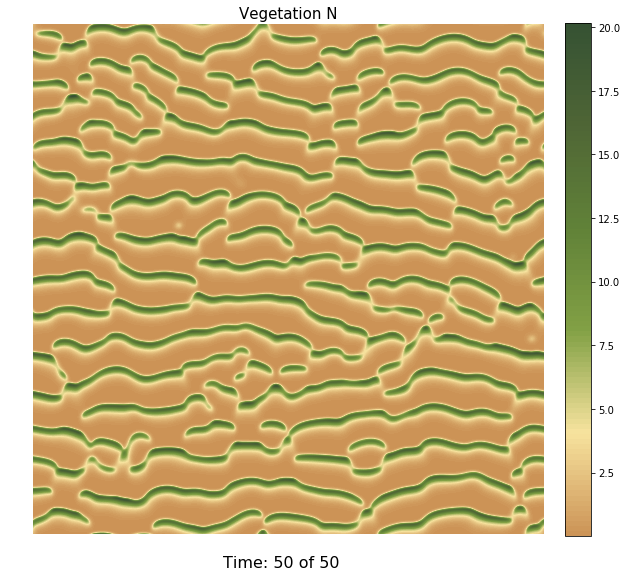

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im=ax.imshow(Ns[:,:,NumPlots-1].T, cmap=VegMap, animated=True, interpolation='bilinear')
ax.set_title('Vegetation N', fontsize=15)
text=fig.suptitle("Time: %1.0f of %1.0f" % (EndTime, EndTime), x=0.47, y=0.12, fontsize=16);
ax.set_axis_off()
f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

## Making a movie

In [13]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ns
    im.set_array(Ns[:,:,i].T)
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime, EndTime));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

© Johan van de Koppel, NIOZ-Yerseke 2018